In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import random
import pandas as pd

from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split

In [2]:
import logging

def get_logger(file_path):
    logger = logging.getLogger()
    log_format = '%(asctime)s | %(message)s'
    formatter = logging.Formatter(log_format, datefmt='%m/%d %I:%M:%S %p')
    file_handler = logging.FileHandler(file_path)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)

    return logger

log_name = '{}'.format(time.strftime("%m%d-%H%M"))
log_path = './log'+'/'+log_name
if not os.path.isdir('log'):
    os.mkdir('log')
if not os.path.isdir(log_path):
    os.mkdir(log_path)
logger = get_logger(os.path.join(log_path, "{}.log".format(log_name)))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
seed = 777

def make_reproducible(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
make_reproducible(seed)

In [5]:
path2csv = './result_label.csv'
df = pd.read_csv(path2csv)

df.head(3)

,filepath,id,smiles,Y
0,./images/DB01100.jpg,DB01100,NS(=O)(=O)C1=CC(=C(Cl)C(Cl)=C1)S(N)(=O)=O,0
1,./images/DB00243.jpg,DB00243,OCCN1CCN(CC\C=C2\C3=C(SC4=C2C=C(Cl)C=C4)C=CC=C...,0
2,./images/DB00572.jpg,DB00572,COC1=C(OC)C=C2C(N)=NC(=NC2=C1)N1CCN(CC1)C(=O)C...,0


In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './images/'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.metadata.iloc[idx, 3]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [7]:
im_size = 224
train_dataset = CustomDataset(df,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [8]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)

11/25 09:28:14 PM | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


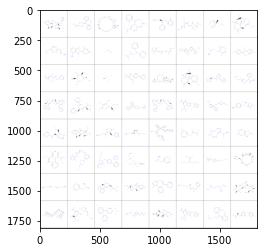

tensor([0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1,
        2, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2,
        0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1])


In [9]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)

images, features = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(features)

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
#num_ftrs = model._fc.in_features # fc의 입력 노드 수를 산출한다. 1000개
#model._fc = nn.Linear(num_ftrs, 2) # fc를 nn.Linear(num_ftrs, 1)로 대체한다.

model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [27]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [17]:
num_epochs = 10
learning_rate = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [25]:
def train(model, train_loader, optimizer, logger):
#    for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
#        print(gt.shape)
#        print(preds.shape)

        loss = loss_func(outputs, gt)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == gt.data)
        run_cnt += len(gt)
        
    cost = running_loss / len(train_loader)
    acc = (running_corrects.double() / run_cnt)*100
    train_loss_list.append(cost)
    train_acc_list.append(acc)
    
    logger.info('train loss: %.4f, train acc: %.4f' %(cost, acc))

In [ ]:
train_loss_list = []
train_acc_list = []

for i in range(num_epochs):
    logger.info("==================== EPOCH :  %d ===================="%i)
    #print('='*20,'EPOCH : ', i,'='*20)
    #print('-'*20,'TRAIN','-'*20)
    train(model, train_loader, opt, logger)
    #print('-'*20,'TEST','-'*20)
#    test(model, test_loader, opt, logger)
    scheduler.step()

11/25 09:32:48 PM | ==================== EPOCH :  0 ====================


torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
